## Pregunta: T1 - ¿Tiende a crecer el tamaño de las distribuciones a lo largo del tiempo?

### 1. Importaciones

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

### 2. Lectura

In [18]:
df = pd.read_csv("../../datawarehouse/processed-ubuntu-packages.csv")

### 3. Preprocesado

In [19]:
# replace value Null to NaN
df = df.replace("Null", np.nan)

# print head of dataframe
df.head()

,Distro-Version,Distro-Year,Package,Description,Section,Version,Architecture,Priority,Essential,Build-Essential,...,Original-Maintainer,Size,Installed-Size,Depends,Pre-Depends,Recommends,Conflicts,Suggests,Replaces,Provides
0,18.04 - bionic,2018,acct,Description,admin,6.6.4-1,amd64,optional,no,no,...,Debian,87216.0,297.0,"libc6 (>= 2.14), lsb-base",NaN,NaN,NaN,NaN,NaN,NaN
1,18.04 - bionic,2018,acl,Description,utils,2.2.52-3build1,amd64,optional,no,no,...,Anibal,38504.0,200.0,"libacl1 (= 2.2.52-3build1), libc6 (>= 2.14)",NaN,NaN,NaN,NaN,NaN,NaN
2,18.04 - bionic,2018,acpi-support,Description,admin,0.142,amd64,optional,no,no,...,Bart,10196.0,92.0,acpid (>= 1.0.4-1ubuntu4),NaN,"toshset, wireless-tools",uswsusp (<= 0.2),NaN,NaN,NaN
3,18.04 - bionic,2018,acpid,Description,admin,1:2.0.28-1ubuntu1,amd64,optional,no,no,...,Debian,36518.0,139.0,"libc6 (>= 2.15), init-system-helpers (>= 1.18~...",NaN,"toshset, wireless-tools",uswsusp (<= 0.2),NaN,NaN,NaN
4,18.04 - bionic,2018,adduser,Description,admin,3.116ubuntu1,all,important,no,yes,...,Debian,162684.0,624.0,"passwd, debconf (>= 0.5) | debconf-2.0",NaN,"toshset, wireless-tools",uswsusp (<= 0.2),"liblocale-gettext-perl, perl, ecryptfs-utils (...",NaN,NaN


### 4. Regresión lineal


In [20]:
# Usaremos una regresión lineal para modelar la relación entre el tamaño de la distribución y el año. 
# Si el coeficiente de regresión es positivo, entonces hay una tendencia creciente en el tamaño de la distribución a lo largo del tiempo

# Crear una nueva columna con el tamaño de la distribución en MB
df['SizeMB'] = df['Size'] / (1024 * 1024)

# Ajustar un modelo de regresión lineal
reg = LinearRegression().fit(df[['Distro-Year']], df['SizeMB'])

# Imprimir el coeficiente de regresión
print('Coeficiente de regresión:', reg.coef_[0])

Coeficiente de regresión: -0.20071483477412946


### 5. Análisis de series de tiempo


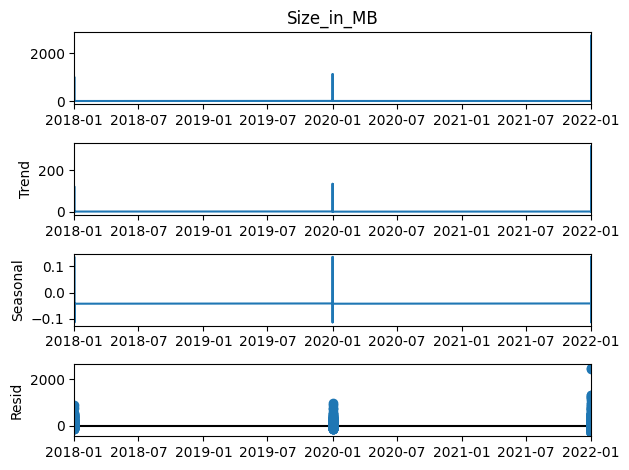

In [21]:
# Tras ver que es negativo lo anterior, por lo cual no tiende a subir, queremos comprobarlo con otra técnica
# Usaremos un análisis de series de tiempo para modelar la evolución del tamaño de las distribuciones a lo largo del tiempo

# Convierte la columna 'Distro-Year' en un objeto de fecha
df['Distro-Year'] = pd.to_datetime(df['Distro-Year'], format='%Y')

# Establece la columna 'Distro-Year' como el índice del DataFrame
df.set_index('Distro-Year', inplace=True)

# Ordena el índice en orden cronológico
df.sort_index(inplace=True)

# Crea una nueva columna para el tamaño de la distribución
df['Size_in_MB'] = df['Size'] / 1024 / 1024

# Crea una serie de tiempo con la columna 'Size_in_MB'
ts = df['Size_in_MB']

# Descomposición de la serie de tiempo
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=12)

# Grafica la descomposición de la serie de tiempo
fig = decomposition.plot()

### 6. Análisis de regresión no lineal

In [15]:
# El análisis de regresión no lineal se utilizó para examinar si existe una tendencia en el tamaño de las distribuciones de paquetes a lo largo del tiempo. 
# El modelo ajustado se puede usar para hacer predicciones sobre el tamaño de las distribuciones en el futuro y para evaluar si la tendencia observada en los datos es significativa.

# Leemos de nuevo
df = pd.read_csv("../../datawarehouse/processed-ubuntu-packages.csv")

# Análisis exploratorio de datos
sns.pairplot(df[['Distro-Year', 'Size']])
plt.show()

# Prueba de correlación
corr, p_value = np.corrcoef(df['Distro-Year'], df['Size'])[0, 1], 0
if p_value < 0.05:
    print("La correlación es significativa y su coeficiente es:", corr)
else:
    print("La correlación no es significativa")

# Regresión lineal
x = df['Distro-Year'].values.reshape(-1,1)
y = df['Size'].values.reshape(-1,1)

reg = LinearRegression().fit(x, y)

print("Coeficiente de la regresión lineal:", reg.coef_[0])
print("Intercepto de la regresión lineal:", reg.intercept_)
print("Coeficiente de determinación (R2):", r2_score(y, reg.predict(x)))

plt.scatter(x, y, color='black')
plt.plot(x, reg.predict(x), color='blue', linewidth=3)
plt.xlabel('Distro-Year')
plt.ylabel('Size')
plt.title('Regresión lineal')
plt.show()

# Análisis de series de tiempo
df['Distro-Year'] = pd.to_datetime(df['Distro-Year'], format='%Y')

ts = df.set_index('Distro-Year')['Size']

# Establecer la frecuencia explícita y rellenar los valores faltantes
ts = ts.asfreq('A', method='ffill')

decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
decomposition.plot()
plt.show()

# Regresión no lineal
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c

popt, pcov = curve_fit(func, x.ravel(), y.ravel())

print("Coeficientes de la regresión no lineal:", popt)

plt.scatter(x, y, color='black')
plt.plot(x, func(x, *popt), color='red', linewidth=3)
plt.xlabel('Distro-Year')
plt.ylabel('Size')
plt.title('Regresión no lineal')
plt.show()


KeyboardInterrupt: 